In [22]:
%load_ext autoreload
%autoreload 2
from common import *
from envs import *
from copy import deepcopy
from RiskAverseMCTS import RiskAverseMCTS
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
N_alpha = 6
N_params = 2
N_rollouts = 50
N_iter = 200
alpha_vals = np.linspace(0.5,1.0,N_alpha)
param_vals = np.arange(N_params)
mdps = [MultiArmedBandit(param=p) for p in param_vals]
rewards = np.zeros([N_alpha, N_params, N_rollouts])
belief = np.ones(N_params, dtype='float')/N_params

We perform a rollout on every MDP with every $\alpha$ value

In [23]:
for i, alpha in enumerate(alpha_vals):
    for j, mdp in enumerate(mdps):
        agent = RiskAverseMCTS(mdps, belief, max_depth=10, 
                               alpha=alpha, max_r=1., n_iter=N_iter )
        env = Env(mdp, agent)
        stats = env.rollout(n_rollouts=N_rollouts, render=False)
        rewards[i,j,:] = stats.total_rewards
        print("\r a =",alpha,"\tmdp",j,"reward:", np.mean(stats.total_rewards), end='', flush='True')
    print("\r a =",alpha,"\tavg_r:",np.mean(rewards[i,:,:]), "\tvar_r:", np.var(np.mean(rewards[i,:,:], axis=1)), flush='True')

 a = 0.5 	avg_r: 0.23 	var_r: 0.0001
 a = 0.6 	avg_r: 0.36 	var_r: 0.04
 a = 0.7 	avg_r: 0.37 	var_r: 0.0961
 a = 0.8 	avg_r: 0.5 	var_r: 0.25
 a = 0.9 	avg_r: 0.5 	var_r: 0.25
 a = 1.0 	avg_r: 0.5 	var_r: 0.25


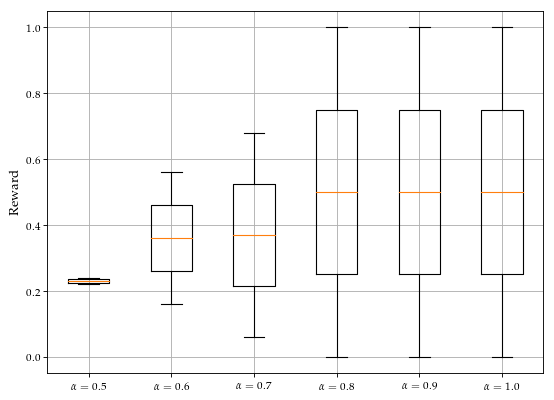

In [24]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
labels = [r"$\alpha="+str(a)+r"$" for a in alpha_vals]
plt.boxplot(np.mean(rewards[:,:,:], axis=2).T, labels=labels)
#plt.title("Distribution of Average Total Cost over Model Uncertainty", fontsize=18)
plt.ylabel("Reward", fontsize=12)
#plt.xlabel("Avg Total Cost under Model", fontsize=16)
plt.legend(fontsize=16)
plt.savefig('bandit_spreads.pdf')
plt.grid(True)
plt.show()

# Convergence plots

In [18]:
belief_curves = []
agent_value_curves = []
adv_value_curves = []
final_q_vals = []
final_n_vals = []
for i, alpha in enumerate(alpha_vals):
    agent = RiskAverseMCTS(mdps, belief, max_depth=5, 
                               alpha=alpha, max_r=1.5, n_iter=200 )
    s0 = mdps[0].reset()
    agent.MCTS(s0)
    belief_curves.append(deepcopy(agent.adv_dists))
    agent_value_curves.append(deepcopy(agent.agent_est_value))
    adv_value_curves.append(deepcopy(agent.adv_est_value))
    final_q_vals.append( [agent.Qha[(s0,a)] for a in mdps[0].action_space(s0)] )
    final_n_vals.append( [agent.Wha[(s0,a)] for a in mdps[0].action_space(s0)] )

In [7]:
(1 - np.array(final_q_vals)).T

array([[ 0.79818574,  0.8095939 ,  0.80149294,  0.77984173,  0.82663454,
         0.79268293],
       [ 0.81648671,  0.75968744,  0.72779776,  0.6963556 ,  0.65766794,
         0.63193117],
       [ 0.83947238,  0.77345295,  0.71237767,  0.65591152,  0.61228114,
         0.58476881],
       [ 0.92991765,  0.84584745,  0.74387332,  0.637718  ,  0.56372831,
         0.50632842]])

In [8]:
np.array(final_n_vals).T

array([[ 24706.15990072,   3581.19795141,   1611.38173593,    803.29979464,
           285.72370649,    246.        ],
       [  9817.82536124,  23168.93986595,  10331.4687811 ,   3017.97781237,
          1643.46171778,   1046.        ],
       [  4572.55003343,  11531.86992073,  22254.62706891,  10160.92161661,
          4236.12636921,   2206.        ],
       [   903.46470461,   1717.99226191,   5802.52241407,  26017.80077638,
         33834.68820653,  36502.        ]])

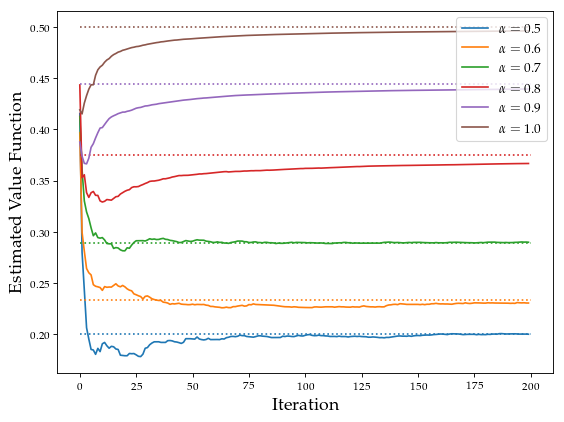

In [19]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
true_vals = 1-np.array([0.8,0.767,0.711,0.625,0.556,0.500])
for i,a in enumerate(alpha_vals):
    h, = plt.plot(np.array(agent_value_curves)[i], label=(r"$\alpha="+str(a)+r"$"))
    plt.plot([0,N_iter],[true_vals[i], true_vals[i]], linestyle=':', color=h.get_color())
#plt.title("Best Q Value", fontsize=18)
plt.ylabel("Estimated Value Function", fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.legend(fontsize=12)
plt.savefig("bandit_value_convergence.pdf")
plt.show()

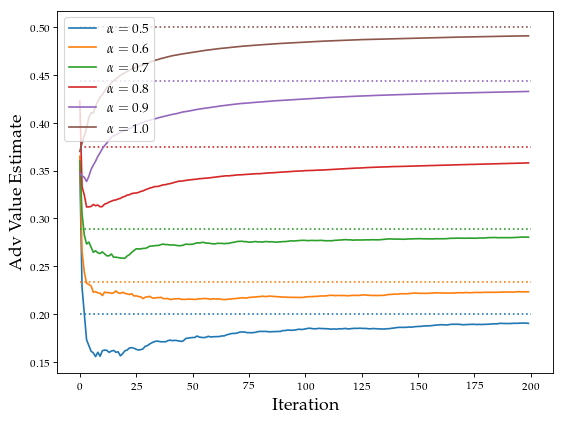

In [20]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for i,a in enumerate(alpha_vals):
    h, = plt.plot(np.array(adv_value_curves)[i], label=(r"$\alpha="+str(a)+r"$"))
    plt.plot([0,N_iter],[true_vals[i], true_vals[i]], linestyle=':', color=h.get_color())
#plt.title("Adv Value Estimate", fontsize=18)
plt.ylabel("Adv Value Estimate", fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.legend(fontsize=12)
plt.show()

In [217]:
belief_curves = np.array(belief_curves)

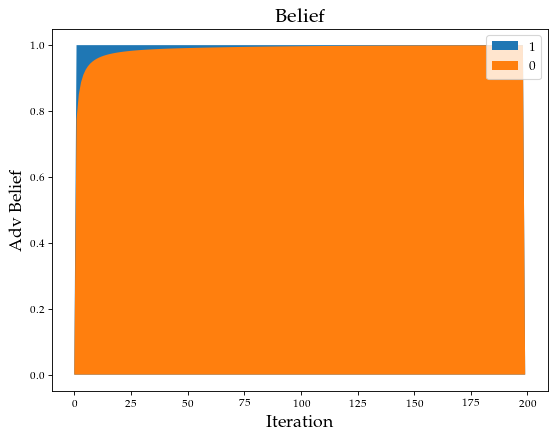

In [21]:
cum_belief_curves = np.cumsum(belief_curves, axis=2)
cum_belief_curves[:,0,:] = 0
cum_belief_curves[:,-1,:] = 0
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for i in reversed(range(N_params)):
    plt.fill(cum_belief_curves[0,:,i], label=str(i))
plt.title("Belief", fontsize=18)
plt.ylabel("Adv Belief", fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.legend(fontsize=12)
plt.show()